In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [12]:
df = pd.read_csv("../data/Cancer_Data.csv")

## Vérification des valeurs manquantes

On visualise les valeurs manquantes avec une heatmap :
- une case claire indique une valeur présente
- une case sombre (ou vide selon le thème) indique une valeur manquante

Objectif : vérifier rapidement si un nettoyage des *NaN* est nécessaire.

<Axes: >

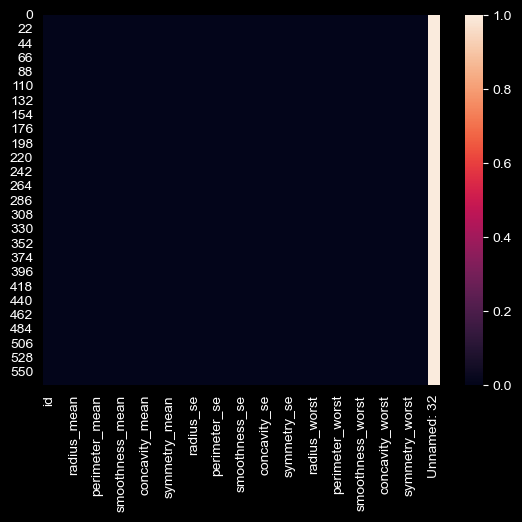

In [13]:
sns.heatmap(df.isnull())

## Sélection des variables utiles

On conserve uniquement :
- la variable cible **diagnosis** (B = bénin / M = malin)
- un ensemble de variables numériques (moyennes) décrivant les caractéristiques de la tumeur

Cela permet de travailler sur un sous-ensemble propre et pertinent du dataset.

## Vérification des types et structure

On utilise `info()` pour :
- vérifier le nombre d’observations et de colonnes
- vérifier les types (`int`, `float`, `object`)
- contrôler l’absence de valeurs manquantes dans les colonnes sélectionnées


In [14]:
colonnes = [
    "diagnosis",
    "radius_mean",
    "texture_mean",
    "perimeter_mean",
    "area_mean",
    "smoothness_mean",
    "compactness_mean",
    "concavity_mean",
    "concave points_mean",
    "symmetry_mean",
    "fractal_dimension_mean"
]

df_copy = df[colonnes].copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   diagnosis               569 non-null    object 
 1   radius_mean             569 non-null    float64
 2   texture_mean            569 non-null    float64
 3   perimeter_mean          569 non-null    float64
 4   area_mean               569 non-null    float64
 5   smoothness_mean         569 non-null    float64
 6   compactness_mean        569 non-null    float64
 7   concavity_mean          569 non-null    float64
 8   concave points_mean     569 non-null    float64
 9   symmetry_mean           569 non-null    float64
 10  fractal_dimension_mean  569 non-null    float64
dtypes: float64(10), object(1)
memory usage: 49.0+ KB


## Encodage de la variable cible

La variable `diagnosis` est catégorielle (B/M).
On la transforme en variable binaire pour les modèles :

- **B (bénin) → 0**
- **M (malin) → 1**

Cela facilite l’utilisation d’algorithmes de classification.


In [15]:
df_copy['diagnosis'] = df_copy['diagnosis'].map({'B': 0, 'M': 1})
df_copy.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


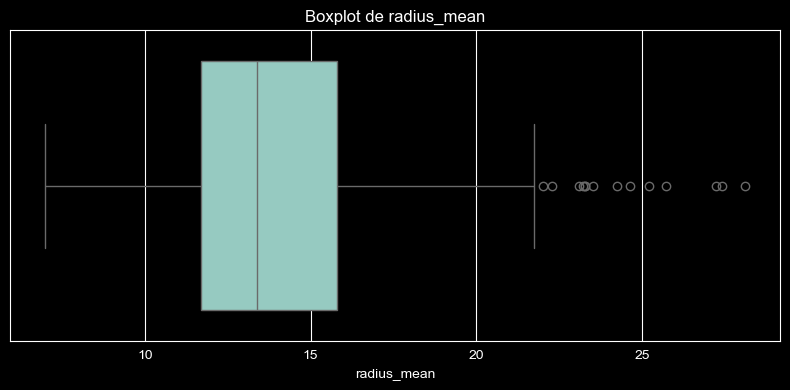

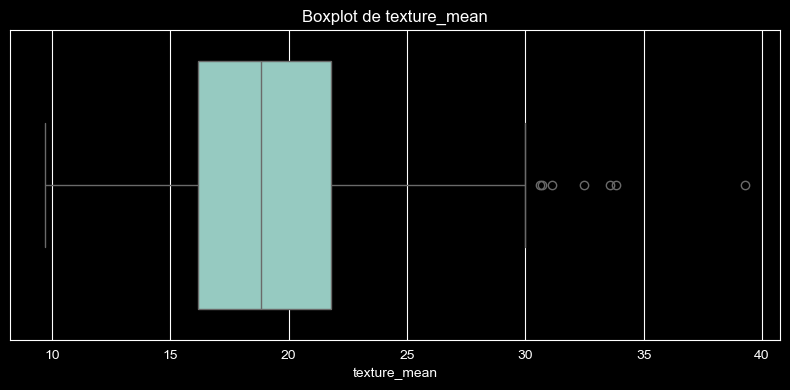

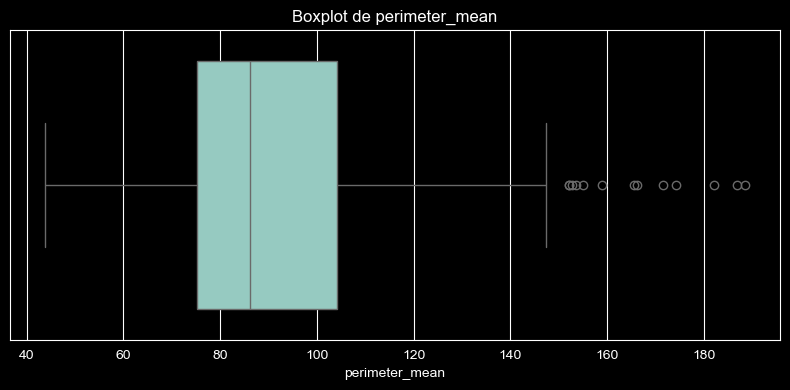

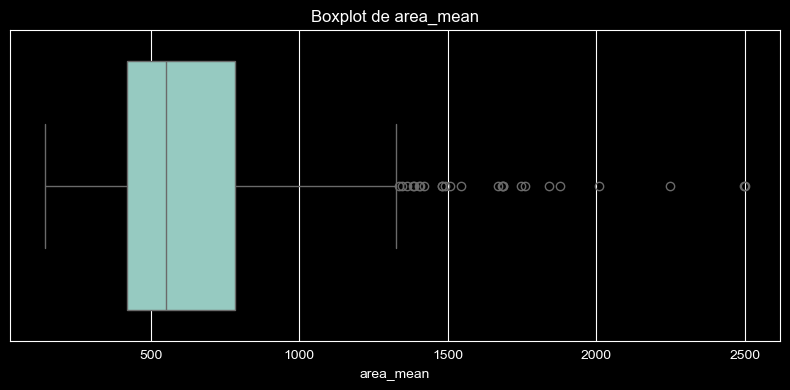

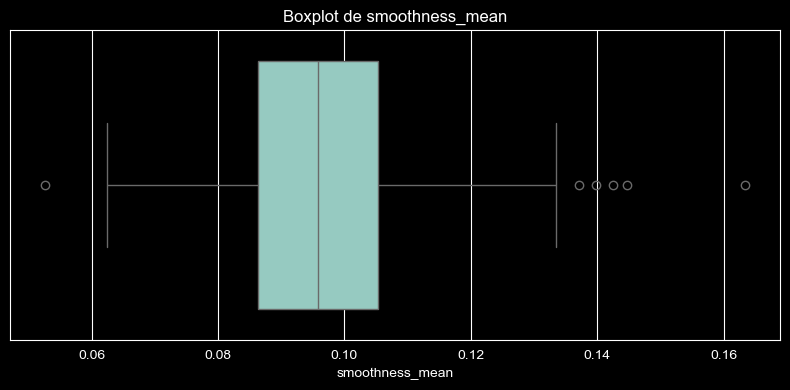

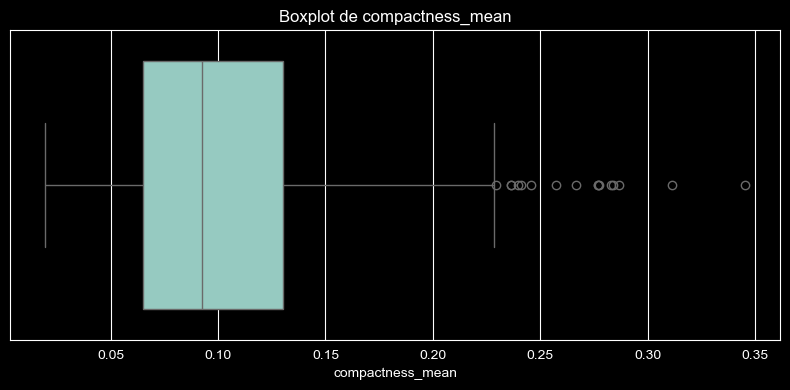

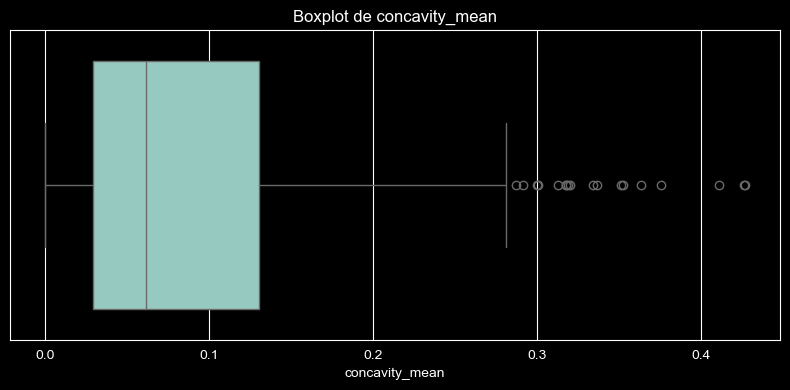

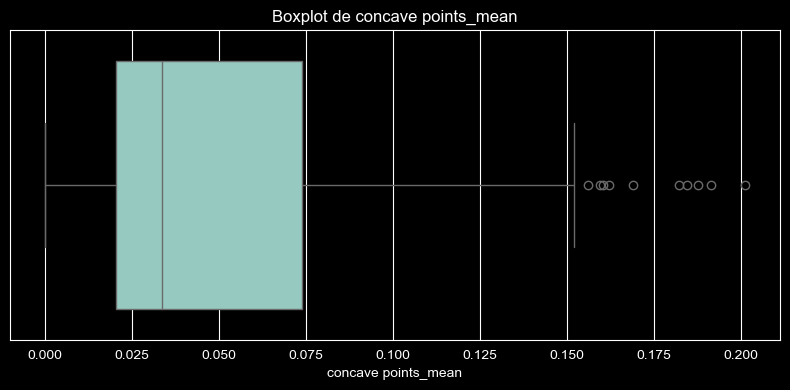

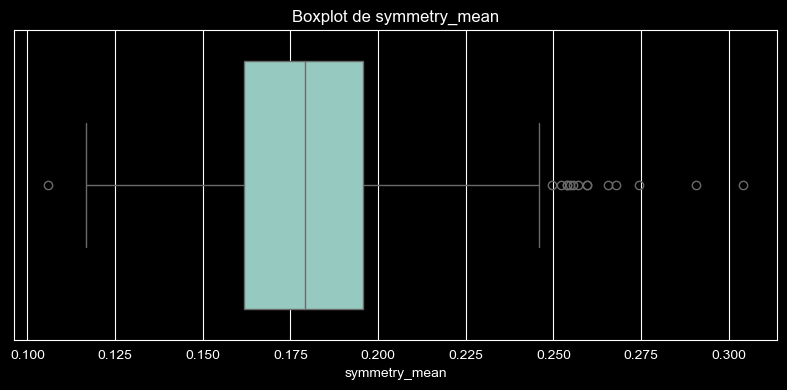

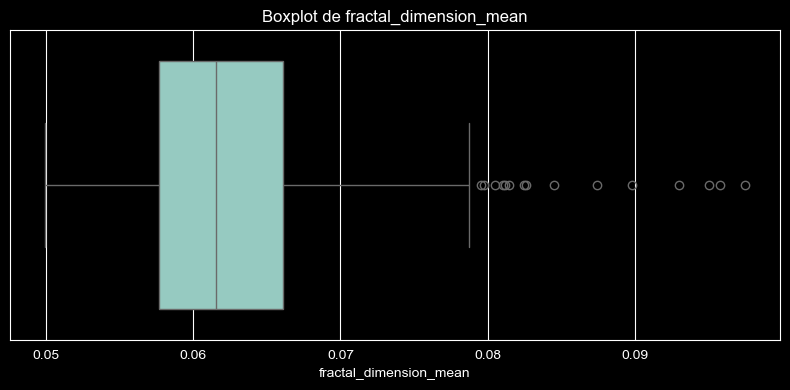

In [22]:
for col in df_copy.columns:
    if col != "diagnosis":
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df_copy[col])
        plt.title(f"Boxplot de {col}")
        plt.tight_layout()
        plt.show()

## Détection des outliers avec la méthode IQR

On définit une fonction `IQR_outliers()` basée sur l’intervalle interquartile (IQR) :

- Q1 = 1er quartile (25%)
- Q3 = 3e quartile (75%)
- IQR = Q3 - Q1
- limite inférieure = Q1 - 1.5 × IQR
- limite supérieure = Q3 + 1.5 × IQR

Toute valeur en dehors de ces limites est considérée comme **outlier**.


In [17]:
def IQR_outliers(df_col: pd.Series) -> tuple:
    Q1 = df_col.quantile(0.25)
    Q3 = df_col.quantile(0.75)
    IQR = Q3 - Q1
    limite_sup = Q3 + 1.5 * IQR
    limite_inf = Q1 - 1.5 * IQR

    return (limite_inf, limite_sup)

In [18]:
df_clean = df_copy.copy()

for col in df_clean.columns:
    if col != "diagnosis":
        inf, sup = IQR_outliers(df_clean[col])
        df_clean = df_clean[
            (df_clean[col] >= inf) &
            (df_clean[col] <= sup)
        ]

print("Ancien dataset :", df_copy.shape)
print("Dataset nettoyé :", df_clean.shape)
print("Nb de données supprimées :", df_copy.shape[0] - df_clean.shape[0])

Ancien dataset : (569, 11)
Dataset nettoyé : (458, 11)
Nb de données supprimées : 111


## Décision concernant les valeurs aberrantes (outliers)

Après détection des valeurs aberrantes à l’aide de la méthode IQR, un nombre non négligeable d’observations a été identifié comme outlier dans plusieurs variables.

Cependant :

- La proportion d’observations concernées reste modérée au regard des 569 observations totales.
- Les valeurs extrêmes apparaissent regroupées entre elles sur les boxplots.
- Ces valeurs correspondent probablement à des tumeurs malignes plus sévères, ce qui est cohérent dans un contexte médical.

Dans un problème de classification, ces observations peuvent contenir une information discriminante importante. Les supprimer risquerait :

- de réduire la taille de l’échantillon,
- de déséquilibrer les classes,
- d’altérer la capacité prédictive du modèle.

Par conséquent, il a été décidé de **conserver l’ensemble des observations** et de ne pas supprimer les outliers.

Une standardisation des variables pourra être appliquée ultérieurement afin de limiter l’influence des différences d’échelle.


## Export du dataset

On enregistre le dataset préparé en CSV pour l’utiliser ensuite dans les étapes de modélisation.


In [19]:
file_path = "../data/data_cleaning.csv"

if not os.path.exists(file_path):
    df_copy.to_csv(file_path, index=False)
    print("Fichier créé.")
else:
    print("Le fichier existe déjà. Aucune écriture effectuée.")

Le fichier existe déjà. Aucune écriture effectuée.
